In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

np.random.seed(333)

df = pd.read_csv('./data/merged_probs_odds.csv') # labels: "home wins" -> 1; "draw": 0; "away" -> -1
df = df.sort_values("date_x", ascending = True)

rename_dict = {"date_x":"date", "prob_tie": "prob_draw", "label":"result"}
df = df.rename(columns=rename_dict)

keep_cols = ['date', 'home_team', 'away_team', 'spi1', 'spi2', 'prob_home', 'prob_draw', 'prob_away', 'odds_home', 'odds_draw',
             'odds_away', 'proj_home_score', 'proj_away_score', 'home_goals', 'away_goals', 'result']
# df = df[keep_cols]
df['result'] = df['result'].map({1: 0, -1: 2, 0: 1}) # 0 = home; 1 = draw; 2 = away
df.tail()

,date,date_y,year,country,league,home_team,away_team,spi1,spi2,prob_home,prob_draw,prob_away,odds_home,odds_draw,odds_away,proj_home_score,proj_away_score,home_goals,away_goals,result
10740,2023-05-08,2/4/2022,2022,England,English League Championship,Birmingham,Sheffield United,38.07,54.97,0.3132,0.2782,0.4086,3.86,3.41,2.00,1.09,1.29,1,2,2
10738,2023-05-08,8/5/2023,2023,Argentina,Argentina Primera Division,San Lorenzo,Defensa y Justicia,45.00,43.75,0.4500,0.3056,0.2445,2.17,2.98,3.75,1.21,0.81,0,0,1
10741,2023-05-09,9/5/2023,2023,Sweden,Swedish Allsvenskan,Hammarby,Mjallby,37.31,21.67,0.5602,0.2552,0.1847,1.67,3.74,5.26,1.69,0.86,0,0,1
10742,2023-05-10,11/5/2023,2023,Brazil,Brasileiro Série A,Cruzeiro,Fluminense,45.37,58.56,0.3419,0.2535,0.4046,2.62,3.15,2.76,1.38,1.52,0,2,2
10743,2023-05-14,5/14/2022,2022,Italy,Italy Serie A,Verona,Torino,52.92,66.14,0.3544,0.3083,0.3373,2.31,3.48,3.10,1.07,1.04,0,1,2


In [2]:
from tqdm import tqdm

def make_trajectories(df, trajectory_len=30, keep_cols=['date', 'home_team', 'away_team', 'spi1', 'spi2', 'prob_home',
                                                        'prob_draw', 'prob_away', 'odds_home', 'odds_draw', 'odds_away',
                                                        'proj_home_score', 'proj_away_score', 'result']):
    num_traj = int(df.shape[0] // trajectory_len)
    trajectories = []
    for _ in tqdm(range(num_traj)):
        df = df.sample(frac=1.0) # shuffle
        traj = df.iloc[:trajectory_len] # keep first {traj_len} random games
        traj = traj.sort_values(by='date', ascending=True) # make game sample chronologic
        trajectories.append(traj[keep_cols])
    return trajectories

In [3]:
traj_list = make_trajectories(df, trajectory_len=5)
len(traj_list)

100%|██████████| 2148/2148 [00:04<00:00, 446.01it/s]


2148

In [4]:
train_list, test_list = traj_list[:1718], traj_list[1718:]
train_df, test_df = pd.concat(train_list), pd.concat(test_list)
train_list[0].head()

,date,home_team,away_team,spi1,spi2,prob_home,prob_draw,prob_away,odds_home,odds_draw,odds_away,proj_home_score,proj_away_score,result
2073,2018-08-15,Vissel Kobe,Sanfrecce Hiroshima,44.82,47.54,0.3681,0.2624,0.3695,2.42,3.40,2.78,1.26,1.27,1
2863,2018-11-11,Tenerife,Albacete,28.22,34.40,0.3891,0.2865,0.3244,1.75,3.25,5.50,1.35,1.21,1
6177,2020-12-05,Auxerre,Niort,37.16,27.63,0.5418,0.2470,0.2112,1.99,3.34,3.70,1.88,1.09,0
8448,2021-12-12,Yeni Malatyaspor,Alanyaspor,28.94,38.22,0.3642,0.2797,0.3561,2.99,3.34,2.33,1.26,1.24,2
10446,2022-12-27,Ankaragucu,Umraniyespor,35.73,28.68,0.5327,0.2521,0.2153,1.89,3.62,3.96,1.67,0.97,2


Trial #4: Fixed Baselines, train policy using PPO2

Sources:

https://colab.research.google.com/drive/1eqODB6TYWUaPq-SG1LD8kVcw1VMqEUyU#scrollTo=juMw2p58Jv8r 

https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/master/3_multiprocessing.ipynb#scrollTo=AvO5BGrVv2Rk 

https://stable-baselines.readthedocs.io/en/master/guide/vec_envs.html

In [5]:
from oddsgym.envs.base_percentage import BasePercentageOddsEnv
from stable_baselines.common import set_global_seeds

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Trial #5: Percentage Baselines, train policy using PPO2

In [6]:
def make_perc_env(train_trajectories, train_feats, env_id, rank, seed=0):
    """
    Utility function for multiprocessed env.
    :param train_trajectories: (list of DataFrames) list with the trajectories to be used for training
    :param train_feats (list of str) the name of the features in the DFs above for the agent to learn from
    :param env_id: (str) the environment ID
    :param seed: (int) the inital seed for RNG
    :param rank: (int) index of the subprocess
    """
    def _init():
        main_df = train_trajectories[env_id][train_feats]
        results_df = train_trajectories[env_id]["result"].tolist()
        env = BasePercentageOddsEnv(main_df=main_df, odds_column_names=["odds_home", "odds_draw", "odds_away"], 
                                    num_possible_outcomes=3, results=results_df)
        env.seed(seed + rank)
        return env
    set_global_seeds(seed)
    return _init

In [7]:
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines import PPO2

In [8]:
def train_agent(train_list, train_feats, max_steps=30000):
    num_traj = len(train_list)
    learning_env = DummyVecEnv([make_perc_env(train_list, train_feats, i, i) for i in range(num_traj)])
    model = PPO2(MlpPolicy, learning_env, verbose=1)
    model.learn(total_timesteps=max_steps)
    return model

def evaluate_agent(model, test_list, train_feats, starting_balance=1000, NUM_SIMULATIONS=20):
    #Test model and append total ending rewards 
    eps_length = test_list[0].shape[0]
    num_traj = len(test_list)
    rewards = np.zeros((num_traj, NUM_SIMULATIONS))
    for j in range(NUM_SIMULATIONS):
        for i in range(num_traj):
            main_df = test_list[i][train_feats]
            results = test_list[i]["result"].tolist()
            env = BasePercentageOddsEnv(main_df=main_df, odds_column_names=["odds_home", "odds_draw", "odds_away"],
                                        num_possible_outcomes=3, results=results, starting_bank=starting_balance)
            obs = env.reset()
            for _ in range(eps_length):
                action, _ = model.predict(obs.reshape((1, -1)))
                obs, reward, done, info = env.step(action)
                if done:
                    rewards[i][j] = info['balance']
                    break
    rewards = np.mean(rewards, axis=0) # get the mean of every simulation, across all trajectories
    return rewards

def visualize_performance(rewards, starting_balance, NUM_SIMULATIONS, CONSTRAINT):
    mean_return = round(np.mean(rewards), 2)
    plt.hist(rewards)
    plt.title(f'Multi-Outcome PPO2 \n Ending Bankroll for {NUM_SIMULATIONS} Simulations \n Mean: ${mean_return} \n Constraint: {100*CONSTRAINT}%')
    plt.plot([starting_balance, starting_balance], [0, NUM_SIMULATIONS], 'r--', label='starting balance')
    plt.plot([mean_return, mean_return], [0, NUM_SIMULATIONS], 'b--', label='mean ending return')
    plt.legend(loc='best')
    plt.xlabel('ending amount ($)')
    plt.ylabel('frequency')
    plt.show()

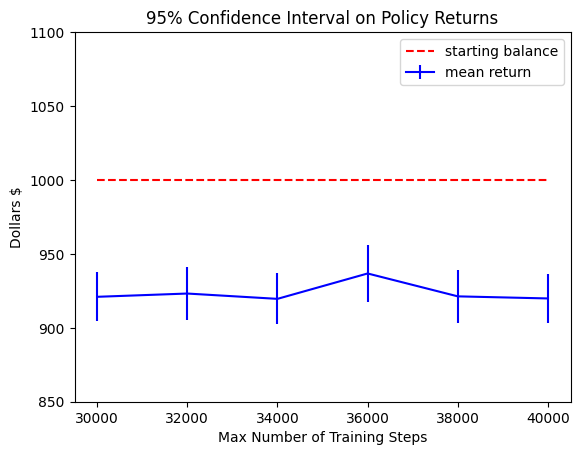

In [19]:
starting_balance = 1000
NUM_SIMULATIONS = 75

train_feats = ['spi1', 'spi2', 'prob_home', 'prob_draw', 'prob_away', 'odds_home', 'odds_draw', 'odds_away',
               'proj_home_score', 'proj_away_score']

step_values = np.arange(30000, 40000+1, 2000)
mean_rewards = np.zeros(len(step_values))
median_rewards = np.zeros(len(step_values))
std_rewards = np.zeros(len(step_values))

for i in tqdm(range(len(step_values))):
    st = step_values[i]
    agent = train_agent(train_list, train_feats, max_steps=st)
    rewards = evaluate_agent(agent, test_list, train_feats, starting_balance=starting_balance, NUM_SIMULATIONS=NUM_SIMULATIONS)
    mean_rewards[i] = np.mean(rewards)
    median_rewards[i] = np.median(rewards)
    std_rewards[i] = np.std(rewards)

plt.errorbar(step_values, mean_rewards, yerr=(1.96/np.sqrt(NUM_SIMULATIONS))*std_rewards, c='blue', label='mean return')
# plt.plot(step_values, median_rewards, c='green', label='median return')
plt.plot([step_values[0], step_values[-1]], [starting_balance, starting_balance], 'r--', label='starting balance')
plt.title('95% Confidence Interval on Policy Returns')
plt.ylim([850, 1100])
plt.xlabel('Max Number of Training Steps')
plt.ylabel('Dollars $')
plt.legend(loc='best')